In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import sklearn
from sklearn.datasets import make_classification
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
%matplotlib inline

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()
# plt.rcParams["font.family"] = "Times New Roman"
font = {'family' : 'Times New Roman', 'weight' : 'normal'}
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
### ATC data from DfT
vol = pd.read_csv('../DfT/DfT.csv')
vol['loc_key'] = vol.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
vol['datetime_key'] = vol.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
vol['site_id'] = vol['Site'].astype(int)
# print(vol.nunique(), np.max(vol['Date']), np.min(vol['Date']))
vol = vol[['loc_key', 'datetime_key', 'site_id', 'Volume']]
# vol.head()

### Travel time data from Google API
speed = pd.read_csv('../Google/Google.csv')
speed = speed.fillna(value={'Direction': '-'})
speed['loc_key'] = speed.apply(lambda row: str(row['Site'])+row['Direction'][0], axis=1)
speed['datetime_key'] = speed.apply(lambda row: str(row['Date'])+'_'+str(row['Hour']), axis=1)
# print(speed.nunique(), np.max(speed['Date']), np.min(speed['Date']))
# speed.groupby(['loc_key']).agg({'Orig_lat': 'first', 'Orig_lng': 'first', 'Dest_lat': 'first', 'Dest_lng': 'first'}).to_csv('../Google/Google_locations.csv')
speed = speed[['loc_key', 'datetime_key', 'distance', 'duration', 'duration_in_traffic', 'MajorMinor', 'Note', 'Road Class', 'dft_capacity', 'speed_limit(kph)']]
# speed.head()
print(speed[['Road Class', 'speed_limit(kph)']].drop_duplicates())
speed['dft_capacity0'] = speed['dft_capacity']
# speed['dft_capacity'] /= 2
speed['speed_limit(kph)0'] = speed['speed_limit(kph)']
# speed['speed_limit(kph)'] /= 1.4

### merge volume and speed data by location and time
data = pd.merge(vol, speed, how='inner', on=['loc_key', 'datetime_key'])
data['datetime'] =  pd.to_datetime(data['datetime_key'], format='%Y-%m-%d_%H')
print('Before merge, ATC has {} records, Google has {} records. Merged data has {} records'.format(vol.shape[0], speed.shape[0], data.shape[0]))
print(data[data['loc_key']=='11N'].iloc[150:160])
# print(data.groupby(['loc_key']).agg({'Note': 'first', 'Road Class': 'first', 'MajorMinor': 'first', 'dft_capacity': 'first'}))
# print(np.unique(data['dft_capacity']))

/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


         Road Class  speed_limit(kph)
0             Trunk              48.0
972           Trunk              80.0
1944          Trunk              64.0
2916      Principal              48.0
3888      Principal               NaN
13120     Principal              32.0
15064             B              32.0
16036             B              48.0
17980             C              48.0
19924             C              32.0
20896  Unclassified              48.0
Before merge, ATC has 30994 records, Google has 34989 records. Merged data has 17745 records
     loc_key   datetime_key  site_id  Volume  distance  duration  \
1234     11N   2016-03-07_2       11      18       561       101   
1236     11N   2016-03-07_3       11      17       561       101   
1238     11N   2016-03-07_4       11      14       561       101   
1240     11N   2016-03-07_5       11      42       561       101   
1242     11N   2016-03-07_6       11     152       561       101   
1244     11N   2016-03-07_7       11     42

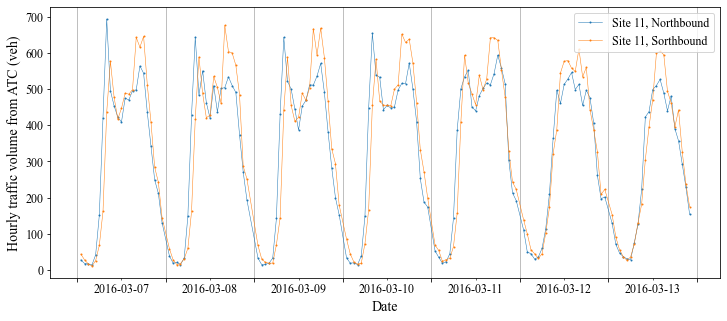

In [3]:
### Vehicle count visualization
sample_data_1 = data.loc[(data['loc_key']=='11N') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]
sample_data_2 = data.loc[(data['loc_key']=='11S') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(sample_data_1['datetime'], sample_data_1['Volume'], lw=0.5, marker='.', markersize=2, label='Site 11, Northbound')
ax.plot(sample_data_2['datetime'], sample_data_2['Volume'], lw=0.5, marker='.', markersize=2, label='Site 11, Sorthbound')
ax.set_xlabel('Date')
ax.set_ylabel('Hourly traffic volume from ATC (veh)')

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=0))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.xaxis.grid(True)
plt.legend()
plt.savefig('../paper_bz/Figures/vehicle_counts_distribution.png', dpi=300, transparent=True)

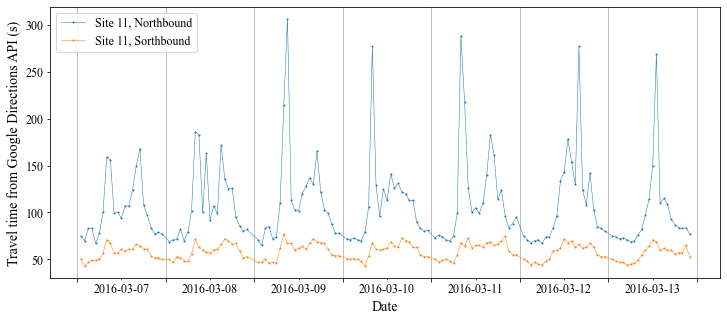

In [4]:
### Journey time visualization
sample_data_1 = data.loc[(data['loc_key']=='11N') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]
sample_data_2 = data.loc[(data['loc_key']=='11S') & (data['datetime']<='2016-03-14') & (data['datetime']>='2016-03-07')]

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(sample_data_1['datetime'], sample_data_1['duration_in_traffic'], lw=0.5, marker='.', markersize=2, label='Site 11, Northbound')
ax.plot(sample_data_2['datetime'], sample_data_2['duration_in_traffic'], lw=0.5, marker='.', markersize=2, label='Site 11, Sorthbound')
ax.set_xlabel('Date')
ax.set_ylabel('Travel time from Google Directions API (s)')

ax.xaxis.set_major_locator(mdates.HourLocator(byhour=0))
ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=12))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.xaxis.grid(True)
plt.legend()
plt.savefig('../paper_bz/Figures/travel_time_distribution.png', dpi=300, transparent=True)

Volume                   1474.000000
duration_in_traffic       192.000000
Volume_for_scale         1474.000000
n_Volume                    0.781548
n_duration_in_traffic       0.245211
Name: 1, dtype: float64
Volume                   659.000000
duration_in_traffic      178.000000
Volume_for_scale         659.000000
n_Volume                   0.949568
n_duration_in_traffic      0.400000
Name: 934, dtype: float64
Volume                   356.000000
duration_in_traffic       46.000000
Volume_for_scale         356.000000
n_Volume                   0.442236
n_duration_in_traffic      0.407080
Name: 10081, dtype: float64


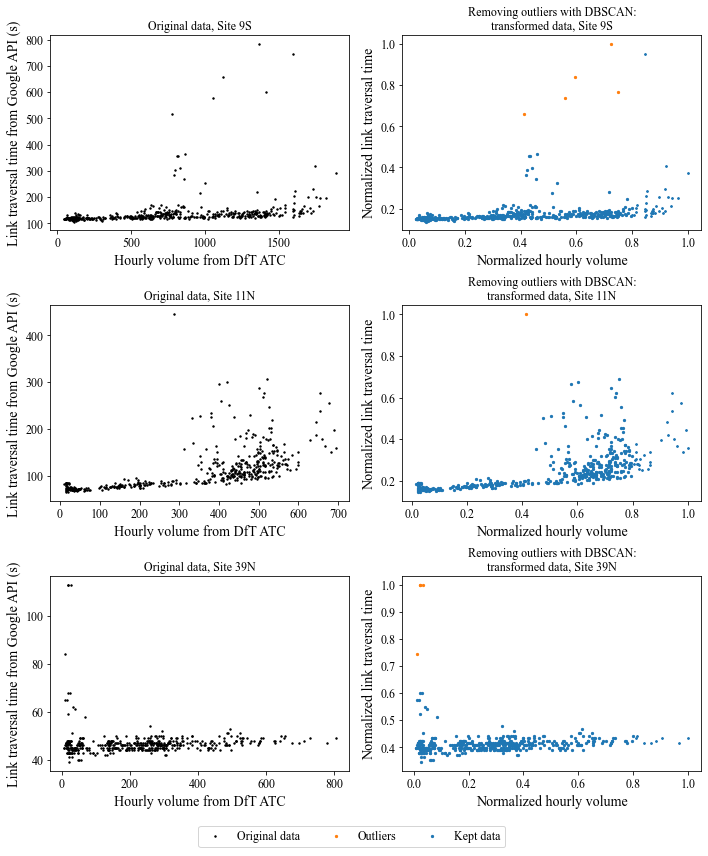

In [5]:
### DBSCAN code based on: https://machinelearningmastery.com/clustering-algorithms-with-python/
### DBSCAN explanation: https://scikit-learn.org/stable/modules/clustering.html#dbscan
fig, ax = plt.subplots(3,2, figsize=(10, 12))
row_id = 0
for site in ['9S', '11N', '39N']:
    sample_location = data.loc[data['loc_key']==site, ['Volume', 'duration_in_traffic']]
    sample_location['Volume_for_scale'] = np.where(sample_location['Volume']>100, sample_location['Volume'], 100)
    sample_location['n_Volume'] = sample_location['Volume']/sample_location['Volume'].max()
    sample_location['n_duration_in_traffic'] = sample_location['duration_in_traffic']/sample_location['duration_in_traffic'].max()
    print(sample_location.iloc[0])
    reserved_df = sample_location.loc[sample_location['n_Volume']>=0.8]
    sample_df = sample_location.loc[sample_location['n_Volume']<0.8]
    sample_data = sample_df[['n_Volume', 'n_duration_in_traffic']].values

    ### plot original data
    ax[row_id, 0].scatter(sample_location['Volume'], sample_location['duration_in_traffic'], s=2, c='k', label='Original data')
    ax[row_id, 0].set_xlabel('Hourly volume from DfT ATC')
    ax[row_id, 0].set_ylabel('Link traversal time from Google API (s)')
    ax[row_id, 0].set_title('Original data, Site {}'.format(site))

    ### plot clustered data
    model = DBSCAN(eps=0.1, min_samples=5)
    yhat = model.fit_predict(sample_data)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if (cluster==-1) or (len(row_ix[0])<5): c, label = u'#ff7f0e', 'Outliers'
        else: c, label = u'#1f77b4', 'Kept data'
        ax[row_id, 1].scatter(reserved_df['n_Volume'], reserved_df['n_duration_in_traffic'], s=2, c=u'#1f77b4')
        ax[row_id, 1].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=label)
    ax[row_id, 1].set_xlabel('Normalized hourly volume')
    ax[row_id, 1].set_ylabel('Normalized link traversal time')
    ax[row_id, 1].set_title('Removing outliers with DBSCAN:\ntransformed data, Site {}'.format(site))
    row_id += 1
handles_1, labels_1 = ax[0,0].get_legend_handles_labels()
handles_2, labels_2 = ax[0,1].get_legend_handles_labels()
fig.legend(handles_1+handles_2, labels_1+labels_2, loc=(0.28, 0.01), ncol=3, prop={'size': 12})
plt.tight_layout()
fig.subplots_adjust(bottom=0.1)
plt.savefig('../paper_bz/Figures/clean.png', dpi=300, transparent=True)
plt.show()

['9N', '9S', '11N', '11S', '15N', '15S', '19E', '19W', '22N', '22S', '25W', '27E', '27W', '31N', '31S', '33N', '33S', '35N', '35S', '36N', '36S', '39N', '39S', '40E', '40W', '42N', '42S', '43E', '43W', '48N', '48S', '66N', '66S', '67N', '67S', '68E', '68W', '74N', '74S']
Data has 17745 points before removing outliers, 17679 after removing outliers


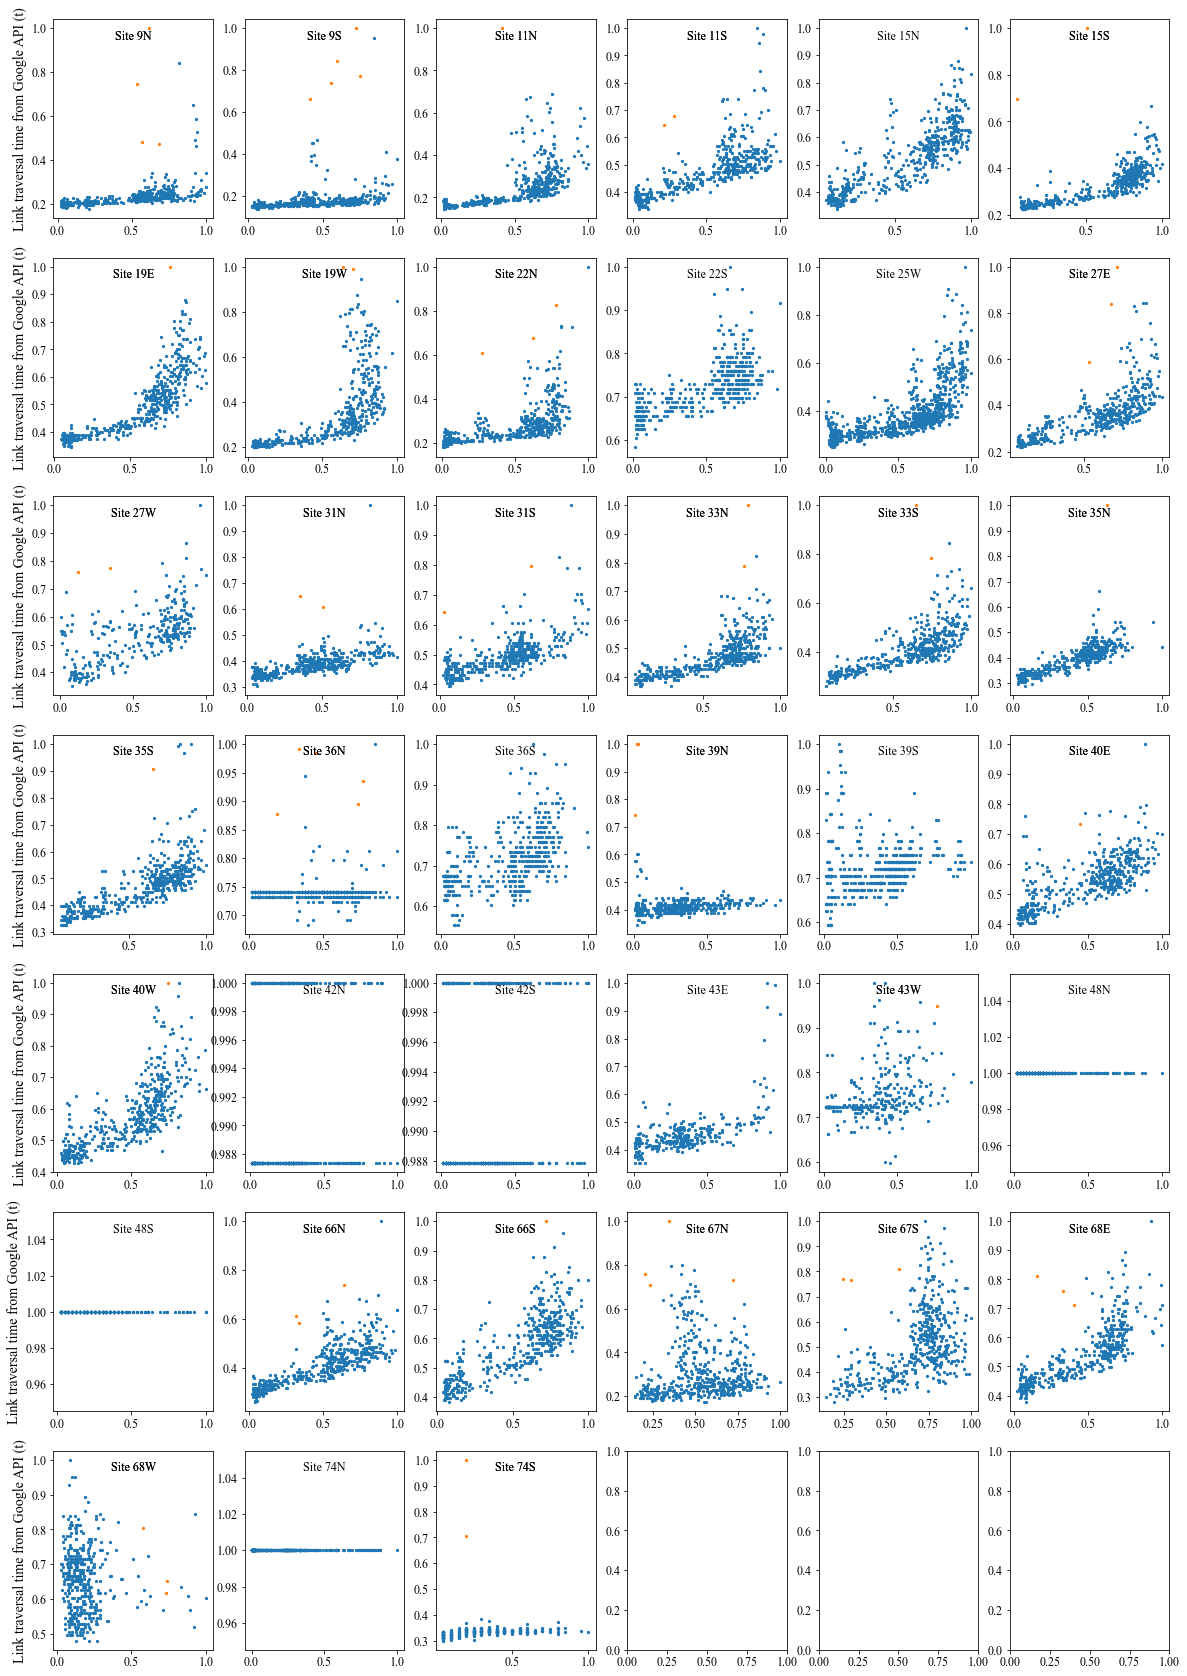

In [6]:
### Showing clustering results for all data
loc_list = data.groupby(['site_id', 'loc_key']).size().index.get_level_values('loc_key').tolist()
print(loc_list)
# print(data.groupby(['site_id', 'loc_key']).size())

filtered_data_list = []
loc_cnt = -1  
fig, ax = plt.subplots(7,6, figsize=(20, 30))
for loc_cnt in range(len(loc_list)):
    row = loc_cnt//6
    col = loc_cnt%6
    ### normalize volume and delay for clustering    
    sample_location = data.loc[data['loc_key']==loc_list[loc_cnt]].copy()
    sample_location['Volume_for_scale'] = np.where(sample_location['Volume']>100, sample_location['Volume'], 100)
    sample_location['n_Volume'] = sample_location['Volume']/sample_location['Volume'].max()
    sample_location['n_duration_in_traffic'] = sample_location['duration_in_traffic']/sample_location['duration_in_traffic'].max()
    reserved_df = sample_location.loc[sample_location['n_Volume']>=0.8]
    sample_df = sample_location.loc[sample_location['n_Volume']<0.8]
    sample_data = sample_df[['n_Volume', 'n_duration_in_traffic']].values
    ### DBSCAN model
    model = DBSCAN(eps=0.1, min_samples=5)
    yhat = model.fit_predict(sample_data)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        if (cluster==-1): c=u'#ff7f0e' 
        else: c=u'#1f77b4'
        ax[row, col].scatter(sample_data[row_ix, 0], sample_data[row_ix, 1], s=5, c=c, label=cluster)
        ax[row, col].text(.5,.9,'Site {}'.format(loc_list[loc_cnt]), horizontalalignment='center', transform=ax[row, col].transAxes)
        if row==9: ax[row, col].set_xlabel('Hourly volume from DfT ATC')
        if col==0: ax[row, col].set_ylabel('Link traversal time from Google API (t)')
    ax[row, col].scatter(reserved_df['n_Volume'], reserved_df['n_duration_in_traffic'], s=5, c=u'#1f77b4')
    filtered_data_list.append(sample_df.iloc[np.where(yhat != -1)])
    filtered_data_list.append(reserved_df)
filtered_data = pd.concat(filtered_data_list)
print('Data has {} points before removing outliers, {} after removing outliers'.format(data.shape[0], filtered_data.shape[0]))

In [7]:
for site in ['36N', '42N', '42S', '48N', '48S', '68W', '74N', '74S', '22S', '36S', '39S', '43W', '31N', '39N', '9N']:
    print(data['Road Class'].iloc[0], np.max(data.loc[data['loc_key']==site, 'Volume']), np.min(data.loc[data['loc_key']==site, 'duration_in_traffic']), np.max(data.loc[data['loc_key']==site, 'duration_in_traffic']))
# np.max(vol.loc[vol['loc_key']=='74S', 'Volume'])

Trunk 53 84 123
Trunk 90 78 79
Trunk 63 81 82
Trunk 51 47 47
Trunk 39 48 48
Trunk 126 59 123
Trunk 334 145 145
Trunk 20 197 656
Trunk 387 56 96
Trunk 386 46 83
Trunk 559 38 64
Trunk 153 138 231
Trunk 497 41 135
Trunk 805 39 113
Trunk 2194 100 565


In [8]:
### normalize volume and travel time
### free flow time (travel time normalization factor): lowest 95 percentile of all observed travel time
### saturation volume (volume normalization factor): average volume of 10 observations when travel_time/free_flow_time is closest to 2.
data_grp = filtered_data[~filtered_data['loc_key'].isin(['36N', '42N', '42S', '48N', '48S', '68W', '74N', '74S', '22S', '36S', '39S', '43W', '31N', '39N', '9N'])].groupby('loc_key')
### 22S, 36S, 39S, 43W: maximum delay < 1.8
data_norm_list = []
for nm, grp in data_grp:
    df = grp.copy()
    df['t_95pct'] = np.percentile(df['duration_in_traffic'], 5)
    df['t_norm'] = df['duration_in_traffic']/df['t_95pct']
    sat_df = df[(df['t_norm']>1.8) & (df['t_norm']<2.2)]
    if sat_df.shape[0] == 0:
        print(nm)
        sat_df = df.copy()
        sat_df['abs_t_norm_minus_2'] = np.abs(sat_df['t_norm'] - 2)
        sat_df = sat_df.nsmallest(30, 'abs_t_norm_minus_2')
    df['v_sat'] = np.percentile(sat_df['Volume'], 95)#np.average(sat_df['Volume'])
    df['v_norm'] = df['Volume']/df['v_sat']
    print(grp[['loc_key', 'Road Class']].iloc[0].values, df.shape[0], df[df['v_norm']>=1].shape[0], df[df['v_norm']>1].shape[0]/df.shape[0])
#     if nm=='9S': print(sat_df, df.iloc[0])
    data_norm_list.append(df)
data_norm = pd.concat(data_norm_list)
print(data_norm.groupby('loc_key').agg({'distance': 'first', 'speed_limit(kph)': 'first', 't_95pct': 'first', 'dft_capacity':'first', 'v_sat': 'first'}).reset_index(drop=False))

['11N' 'Principal'] 466 15 0.032188841201716736
['11S' 'Principal'] 465 15 0.03225806451612903
['15N' 'Principal'] 467 16 0.034261241970021415
['15S' 'Principal'] 465 5 0.010752688172043012
['19E' 'Principal'] 466 7 0.015021459227467811
['19W' 'Principal'] 465 7 0.015053763440860216
['22N' 'Principal'] 464 11 0.023706896551724137
['25W' 'Principal'] 932 16 0.017167381974248927
['27E' 'Principal'] 464 9 0.01939655172413793
['27W' 'Principal'] 285 1 0.0035087719298245615
['31S' 'Principal'] 465 9 0.01935483870967742
['33N' 'Principal'] 465 38 0.07526881720430108
['33S' 'Principal'] 465 4 0.008602150537634409
['35N' 'B'] 466 99 0.21244635193133046
['35S' 'B'] 466 3 0.006437768240343348
['40E' 'C'] 466 19 0.0407725321888412
['40W' 'C'] 466 7 0.015021459227467811
['43E' 'Unclassified'] 329 10 0.02735562310030395
['66N' 'Trunk'] 464 3 0.00646551724137931
['66S' 'Trunk'] 466 10 0.02145922746781116
['67N' 'Principal'] 463 42 0.09071274298056156
['67S' 'Principal'] 464 18 0.03879310344827586
['

(24, 9) 1.3829576121031053 0.7955007435762783 0.3411798161329411
   loc_key    Road Class  distance  speed_limit(kph)  t_95pct  dft_capacity  \
0      11N     Principal       561              48.0     70.0        1650.0   
1      11S     Principal       561              48.0     46.0        1650.0   
2      15N     Principal      1039              48.0    108.0        1650.0   
3      15S     Principal      1039              48.0     96.0        1650.0   
4      19E     Principal       656              48.0     58.0        1650.0   
5      19W     Principal       656              48.0     76.0        1650.0   
6      22N     Principal       759              48.0     70.0        1650.0   
7      25W     Principal       631              48.0     58.0        1650.0   
8      27E     Principal      1001              48.0    103.0        1650.0   
9      27W     Principal      1001              48.0    104.0        1650.0   
10     31S     Principal       463              32.0     43.0     

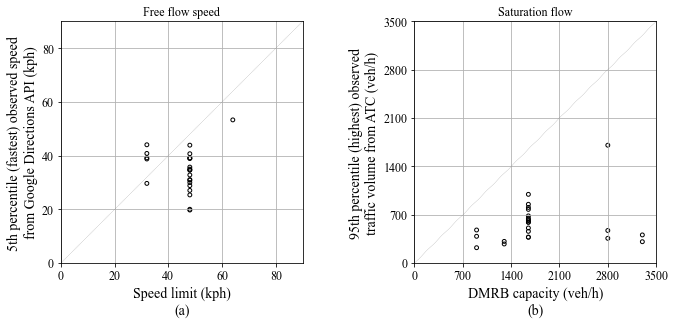

In [9]:
### free flow time, observed vs design
fft_grp = data_norm.groupby('loc_key').agg({'Road Class': 'first', 'distance': 'first', 'speed_limit(kph)': 'first', 't_95pct': 'first', 'dft_capacity':'first', 'v_sat': 'first'}).reset_index(drop=False)
fft_grp['t_design'] = fft_grp['distance']/fft_grp['speed_limit(kph)']*3.6
fft_grp['speed_obs(kph)'] = (fft_grp['distance']/fft_grp['t_95pct'])*3.6
print(fft_grp.shape, np.mean(fft_grp['t_95pct']/fft_grp['t_design']), np.mean(fft_grp['speed_obs(kph)']/fft_grp['speed_limit(kph)']), np.mean(fft_grp['v_sat']/fft_grp['dft_capacity']))
print(fft_grp)
fig, ax = plt.subplots(1, 2, figsize=(10,4.5))
fig.tight_layout()
### Free flow time
# ax[0].scatter(fft_grp['t_design'], fft_grp['t_95pct'], s=15, facecolors='none', edgecolors='k')
# ax[0].set_xlim(0, 150)
# ax[0].set_ylim(0, 150)
# ax[0].set_xticks(np.arange(0, 160, 30))
# ax[0].set_yticks(np.arange(0, 160, 30))
# ax[0].set_xlabel('Free flow travel time based on speed limit (sec)\n(a)')
# ax[0].set_ylabel('5th percentile (fastest) observed travel time\nfrom Google Directions API (sec)')
# ax[0].set_title('Free flow travel time')
ax[0].scatter(fft_grp['speed_limit(kph)'], fft_grp['speed_obs(kph)'], s=15, facecolors='none', edgecolors='k')
ax[0].plot([0,100], [0,100], lw=0.5, ls=':', c='gray')
ax[0].set_xlim(0, 90)
ax[0].set_ylim(0, 90)
ax[0].set_xticks(np.arange(0, 100, 20))
ax[0].set_yticks(np.arange(0, 100, 20))
ax[0].set_xlabel('Speed limit (kph)\n(a)')
ax[0].set_ylabel('5th percentile (fastest) observed speed\nfrom Google Directions API (kph)')
ax[0].set_title('Free flow speed')
ax[0].grid(True)
ax[0].set_aspect('equal', adjustable='box')
### Capacity
ax[1].scatter(fft_grp['dft_capacity'], fft_grp['v_sat'], s=15, facecolors='none', edgecolors='k')
ax[1].plot([0,3500], [0,3500], lw=0.5, ls=':', c='gray')
ax[1].set_xlim(0, 3500)
ax[1].set_ylim(0, 3500)
ax[1].set_xticks(np.arange(0, 4100, 700))
ax[1].set_yticks(np.arange(0, 4100, 700))
ax[1].set_xlabel('DMRB capacity (veh/h)\n(b)')
ax[1].set_ylabel('95th percentile (highest) observed\ntraffic volume from ATC (veh/h)')
ax[1].set_title('Saturation flow')
ax[1].grid(True)
ax[1].set_aspect('equal', adjustable='box')
### Plotting
plt.rc('grid', linestyle=":", color='black')
fig.subplots_adjust(bottom=0.2)
plt.savefig('../paper_bz/Figures/high_res/fft_cap_design_observe.tif', dpi=300, transparent=True)
plt.savefig('../paper_bz/Figures/fft_cap_design_observe_notext.png', dpi=300, transparent=True)
# plt.show()

{'11N': 466, '11S': 465, '15N': 467, '15S': 465, '19E': 466, '19W': 465, '22N': 464, '25W': 932, '27E': 464, '27W': 285, '31S': 465, '33N': 465, '33S': 465, '35N': 466, '35S': 466, '40E': 466, '40W': 466, '43E': 329, '66N': 464, '66S': 466, '67N': 463, '67S': 464, '68E': 420, '9S': 462}
0.42750175364570453 1.1560005103117599 (462, 22)
1.2339397368906933 1.6760726239369284 (466, 22)
0.6725898277631855 1.467523932690623 (466, 22)


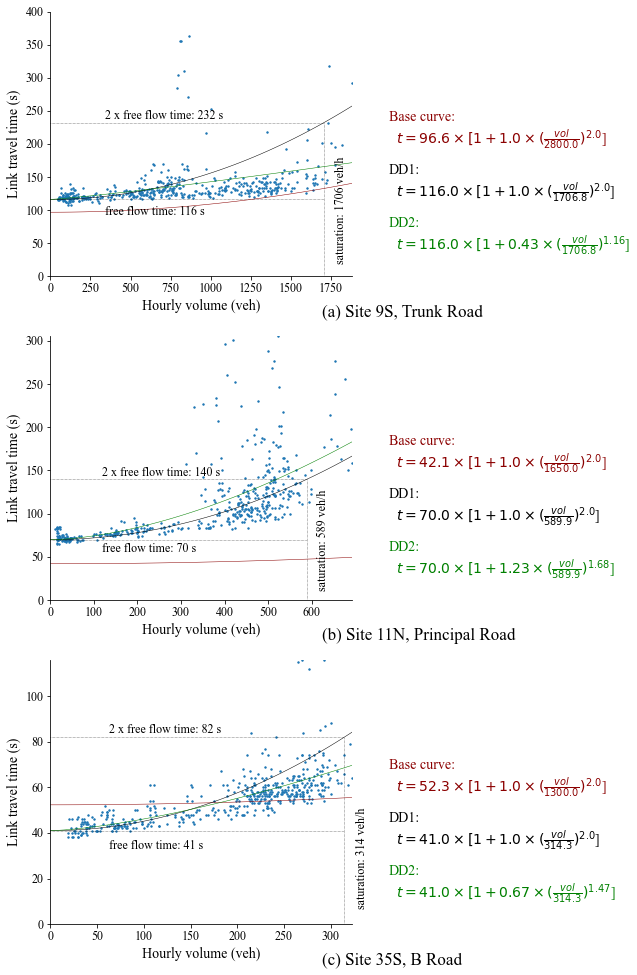

In [10]:
from lmfit import Model
print(data_norm.groupby('loc_key').size().to_dict())
selected_sites = ['9S', '11N', '35S']
# selected_sites = ['66N', '66S', '67N']

def fitfun(x, t0, alpha, beta, cap):
    return t0*(1+alpha*(x/cap)**beta)

fig, ax = plt.subplots(3, 1, figsize=(10, 14))
fig.tight_layout(pad=3)
col_id = -1
fig_label={0:'(a)', 1: '(b)', 2: '(c)'}
for site in selected_sites:
    col_id += 1
    ### site data
    df = data_norm.loc[data_norm['loc_key']==site]
    ### infer fft and cap
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    ### observed data
#     ax[col_id].set_title('Site {}'.format(site))
    ax[col_id].scatter(df['Volume'], df['duration_in_traffic'], s=2)
#     print(np.percentile(df['Volume'], 95))
    ax[col_id].set_xlim([0, np.max(df['Volume'])])
    ax[col_id].set_ylim([0, np.max(df['duration_in_traffic'])])
    if site=='9S': ax[col_id].set_ylim([0, 400])
    ax[col_id].set_xlabel('Hourly volume (veh)')
    ax[col_id].set_ylabel('Link travel time (s)')
    # Hide the right and top spines
    ax[col_id].spines['right'].set_visible(False)
    ax[col_id].spines['top'].set_visible(False)
    ax[col_id].spines['left'].set_position('zero')
    ax[col_id].spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
    ax[col_id].yaxis.set_ticks_position('left')
    ax[col_id].xaxis.set_ticks_position('bottom')
    # Add capacity reference
    ax[col_id].vlines(x=cap, ymin=0, ymax=fft*2, lw=0.5, ls=':')
    ax[col_id].hlines(y=fft*2, xmin=0, xmax=cap, lw=0.5, ls=':')
    ax[col_id].hlines(y=fft, xmin=0, xmax=cap, lw=0.5, ls=':')
    ax[col_id].text(cap*1.04, fft*0.2, 'saturation: {} veh/h'.format(int(cap)), rotation=90)
    ax[col_id].text(cap/5, fft*2.05, '2 x free flow time: {} s'.format(int(fft*2)))
    ax[col_id].text(cap/5, fft*0.8, 'free flow time: {} s'.format(int(fft)))
    
    ### Add DfT capacity and speed limit
    x_curve = np.linspace(0, np.max(df['Volume'])*1.1, 50)
    dft_fft = df['distance'].iloc[0]/df['speed_limit(kph)'].iloc[0]*3.6 ### Believed free flow time in seconds
    dft_cap = df['dft_capacity'].iloc[0]
    y_dft = (1 + (x_curve/dft_cap)**2)*dft_fft
    ax[col_id].plot(x_curve, y_dft, c='darkred', lw=0.5, label='DfT BPR')
    ### Data driven 1
    y_m1 = (1 + (x_curve/cap)**2)*fft
    ax[col_id].plot(x_curve, y_m1, c='k', lw=0.5, label='DD1')
    
    ### Fit non-linear
    mymodel = Model(fitfun)
    params = mymodel.make_params(alpha=1, beta=2)
    params['t0'].vary = False
    params['cap'].vary = False
    params['t0'].value = fft
    params['cap'].value = cap
    result = mymodel.fit(df['duration_in_traffic'], params, x=df['Volume'])
    r_alpha = result.params['alpha'].value
    r_beta = result.params['beta'].value
    print(r_alpha, r_beta, df.shape)
    ax[col_id].plot(x_curve, fitfun(x_curve, fft, r_alpha, r_beta, cap), c='g', lw=0.5, label='DD2')
    
    ### text
    ax[col_id].text(1.12, 0.5, 'Base curve:\n'+r'  $t = {:.1f}\times[1+{:.1f}\times(\frac{{vol}}{{{:.1f}}})^{{{:.1f}}}$]'.format(dft_fft, 1.0, dft_cap, 2), c='darkred', transform = ax[col_id].transAxes, size=14)
    ax[col_id].text(1.12, 0.3, 'DD1:\n'+r'  $t = {:.1f}\times[1+{:.1f}\times(\frac{{vol}}{{{:.1f}}})^{{{:.1f}}}$]'.format(fft, 1.0, cap, 2), c='k', transform = ax[col_id].transAxes, size=14)
    ax[col_id].text(1.12, 0.1, 'DD2:\n'+r'  $t = {:.1f}\times[1+{:.2f}\times(\frac{{vol}}{{{:.1f}}})^{{{:.2f}}}$]'.format(fft, r_alpha, cap, round(r_beta, 2)), c='g', transform = ax[col_id].transAxes, size=14)
    ax[col_id].text(0.9, -0.15, '{} Site {}, {} Road'.format(fig_label[col_id], site, df['Road Class'].iloc[0]), transform = ax[col_id].transAxes, size=17)

fig.subplots_adjust(right=0.5)
plt.savefig('../paper_bz/Figures/high_res/curve_fit.tif', dpi=300, transparent=True)
plt.savefig('../paper_bz/Figures/curve_fit.png', dpi=300, transparent=True)

['11N' '11S' '15N' '15S' '19E' '19W' '22N' '25W' '27E' '27W' '31S' '33N'
 '33S' '35N' '35S' '40E' '40W' '43E' '66N' '66S' '67N' '67S' '68E' '9S']
555
718
                   MAE_u                             Obs_counts                \
VOC_ratio          0-25% 25-50% 50-75% 75-100% >100%      0-25% 25-50% 50-75%   
Road Class   Model                                                              
B            DD1     1.8    2.3    4.6     6.7   8.6        179    125    183   
             DD2     1.8    2.1    2.2     2.1   2.2        179    125    183   
             DfT     9.0    6.6    4.3     3.5   3.8        179    125    183   
C            DD1     1.8    2.1    2.3     3.4   4.9        245    100    306   
             DD2     1.7    1.9    1.6     1.7   1.5        245    100    306   
             DfT    20.7   21.9   21.6    21.1  19.4        245    100    306   
Principal    DD1     1.9    2.2    2.9     2.8   3.4       1641   1082   1996   
             DD2     1.8    2.0    2

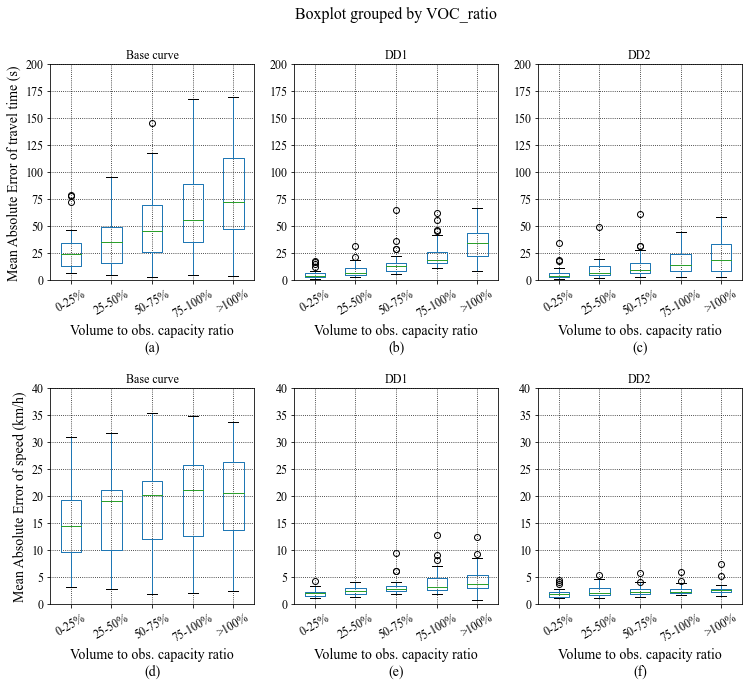

In [11]:
### Mean Absolute Error

def mae(alpha, beta, t0, vc, x_obs, y_obs):
    y_model = t0*(1+alpha*(x_obs/vc)**beta)
    return np.mean(np.absolute(y_model-y_obs))

def mae_speed(alpha, beta, t0, vc, x_obs, y_obs, length):
    y_model = t0*(1+alpha*(x_obs/vc)**beta)
    speed_model = length/y_model
    speed_obs = length/y_obs
    return np.mean(np.absolute(speed_model-speed_obs))*3.6

def fitfun(x, t0, alpha, beta, cap):
    return t0*(1+alpha*(x/cap)**beta)

print(np.unique(data_norm['loc_key']))
mae_l = []
for nm, grp in data_norm.groupby('loc_key'):
#     print(nm)
    cap_obs = grp['v_sat'].iloc[0]
    road_length = grp['distance'].iloc[0]
    if nm in ['67N', '67S']: print(road_length)
    quarter_data = {'0-25%':grp[grp['Volume']<=cap_obs*0.25],
                    '25-50%':grp[(grp['Volume']<=cap_obs*0.5) & (grp['Volume']>cap_obs*0.25)],
                    '50-75%':grp[(grp['Volume']<=cap_obs*0.75) & (grp['Volume']>cap_obs*0.5)],
                    '75-100%':grp[(grp['Volume']<=cap_obs*1) & (grp['Volume']>cap_obs*0.75)],
                    '>100%':grp[grp['Volume']>cap_obs]}
    ### DfT coefficients
    alpha, beta, t0, vc, road_class = 1, 2, grp['distance'].iloc[0]/grp['speed_limit(kph)'].iloc[0]*3.6, grp['dft_capacity'].iloc[0], grp['Road Class'].iloc[0]
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DfT', q_id, nm, road_class, q_data.shape[0],
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
    ### Data driven 1
    alpha, beta, t0, vc = 1, 2, grp['t_95pct'].iloc[0], grp['v_sat'].iloc[0]
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DD1', q_id, nm, road_class, q_data.shape[0],
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
    ### Data driven 2
    t0, vc = grp['t_95pct'].iloc[0], grp['v_sat'].iloc[0]
    mymodel = Model(fitfun)
    params = mymodel.make_params(alpha=1, beta=2)
    params['t0'].vary = False
    params['cap'].vary = False
    params['t0'].value = t0
    params['cap'].value = vc
    result = mymodel.fit(grp['duration_in_traffic'], params, x=grp['Volume'])
    alpha = result.params['alpha'].value
    beta = result.params['beta'].value
    for q_id, q_data in quarter_data.items():
        mae_l.append(['DD2', q_id, nm, road_class, q_data.shape[0],
                  mae(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic']),
                  mae_speed(alpha, beta, t0, vc, q_data['Volume'], q_data['duration_in_traffic'], road_length)])
#     break
mae_df = pd.DataFrame(mae_l, columns=['Model', 'VOC_ratio', 'Site', 'Road Class', 'Obs_counts', 'MAE_t', 'MAE_u'])
print(mae_df.groupby(['Road Class', 'VOC_ratio', 'Model']).agg({'MAE_u': np.median, 'Obs_counts': np.sum}).unstack('VOC_ratio').round(1))
# print(mae_df.groupby(['Road Class', 'Model']).agg({'MAE_u': np.median, 'Obs_counts': np.sum}).unstack('Model').round(1))

fig, ax = plt.subplots(2,3, figsize=(12,10))
fig.tight_layout(pad=0.5)
plt.subplots_adjust(bottom=0.5, hspace=0.5)
# for site, grp in mae_df.groupby('Site'):
#     col_id = -1
#     for model in ['DfT', 'DD1', 'DD2']:
#         col_id += 1
#         ### Travel time
#         ax[0,col_id].plot(grp.loc[grp['Model']==model, 'Quartile'], grp.loc[grp['Model']==model, 'MAE_t'], ls='-', lw=0.5, marker='.', ms=5)
#         ### Speed
#         ax[1,col_id].plot(grp.loc[grp['Model']==model, 'Quartile'], grp.loc[grp['Model']==model, 'MAE_u'], ls='-', lw=0.5, marker='.', ms=5)
col_id = -1
for model in ['DfT', 'DD1', 'DD2']:
    col_id += 1
    ### travel time
    mae_df.loc[mae_df['Model']==model].boxplot(column='MAE_t', by='VOC_ratio', ax=ax[0, col_id])
    ### speed
    mae_df.loc[mae_df['Model']==model].boxplot(column='MAE_u', by='VOC_ratio', ax=ax[1, col_id])
ax[0,0].set_ylabel('Mean Absolute Error of travel time (s)')
ax[1,0].set_ylabel('Mean Absolute Error of speed (km/h)')
ax[0,0].set_title('DfT BPR')
plt.setp(ax[:,0], title='Base curve')
plt.setp(ax[:,1], title='DD1')
plt.setp(ax[:,2], title='DD2')
plt.setp(ax[0,0], ylim=[0,200], xlabel='Volume to obs. capacity ratio\n(a)')
plt.setp(ax[0,1], ylim=[0,200], xlabel='Volume to obs. capacity ratio\n(b)')
plt.setp(ax[0,2], ylim=[0,200], xlabel='Volume to obs. capacity ratio\n(c)')
plt.setp(ax[1,0], ylim=[0,40], xlabel='Volume to obs. capacity ratio\n(d)')
plt.setp(ax[1,1], ylim=[0,40], xlabel='Volume to obs. capacity ratio\n(e)')
plt.setp(ax[1,2], ylim=[0,40], xlabel='Volume to obs. capacity ratio\n(f)')
for ax_i in fig.axes:
    matplotlib.pyplot.sca(ax_i)
    plt.xticks(rotation=30)

plt.savefig('../paper_bz/Figures/high_res/mae.tif', dpi=300, transparent=True)
plt.savefig('../paper_bz/Figures/mae.png', dpi=300, transparent=True)

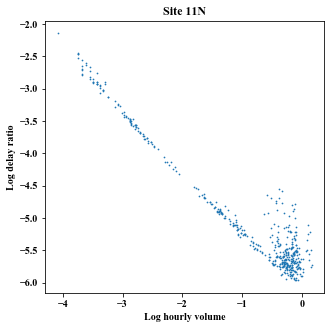

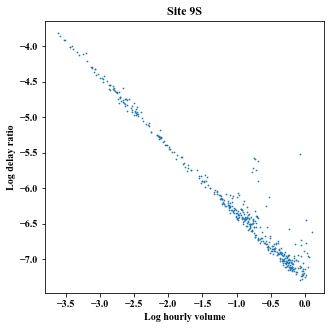

In [17]:
### transform
selected_sites = ['11N', '9S']

for site in selected_sites:
    ### site data
    df = data_norm.loc[data_norm['loc_key']==site]
    ### infer fft and cap
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title('Site {}'.format(site))
    tr_y = np.log((df['duration_in_traffic']/fft)/df['Volume'])
    tr_x = np.log(df['Volume']/cap)
    ax.scatter(tr_x, tr_y, s=0.5)
#     ax.set_xlim([0, np.max(tr_x)])
#     ax.set_ylim([0, np.max(tr_y)])
    ax.set_xlabel('Log hourly volume')
    ax.set_ylabel('Log delay ratio')
    # Hide the right and top spines
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.spines['left'].set_position('zero')
#     ax.spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
#     ax.yaxis.set_ticks_position('left')
#     ax.xaxis.set_ticks_position('bottom')


66N 56.0 408.0
66S 61.0 309.79999999999995
67N 101.10000000000001 358.79999999999995
67S 129.0 472.15


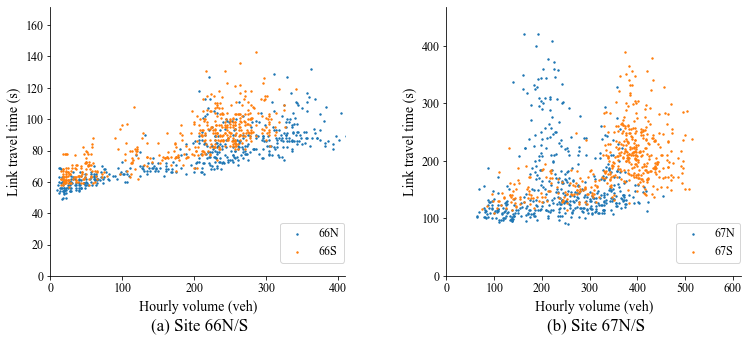

In [14]:
def plot_scatter_points(site, col_id, title=''):
    ### site data
    df = data_norm.loc[data_norm['loc_key']==site]
    ### infer fft and cap
    fft = df['t_95pct'].iloc[0]
    cap = df['v_sat'].iloc[0]
    print(site, fft, cap)
    ### observed data
#     ax[col_id].set_title(title)
    p = ax[col_id].scatter(df['Volume'], df['duration_in_traffic'], s=2)
    ax[col_id].set_xlim([0, np.max(df['Volume']*1.2)])
    ax[col_id].set_ylim([0, np.max(df['duration_in_traffic']*1.2)])
    ax[col_id].set_xlabel('Hourly volume (veh)')
    ax[col_id].set_ylabel('Link travel time (s)')
    ax[col_id].text(0.34,-0.2, title, size=17, transform = ax[col_id].transAxes)
    # Hide the right and top spines
    ax[col_id].spines['right'].set_visible(False)
    ax[col_id].spines['top'].set_visible(False)
    ax[col_id].spines['left'].set_position('zero')
    ax[col_id].spines['bottom'].set_position('zero')
    # Only show ticks on the left and bottom spines
    ax[col_id].yaxis.set_ticks_position('left')
    ax[col_id].xaxis.set_ticks_position('bottom')
    # Add capacity reference
#     ax[col_id].vlines(x=cap, ymin=0, ymax=fft*2, lw=0.5, ls=':')
#     ax[col_id].hlines(y=fft*2, xmin=0, xmax=cap, lw=0.5, ls=':')
#     ax[col_id].hlines(y=fft, xmin=0, xmax=cap, lw=0.5, ls=':')
#     ax[col_id].text(cap*1.02, fft*1.5, 'saturation flow:\n{} veh/hr'.format(int(cap)))
#     ax[col_id].text(cap/5, fft*2.05, '2 x free flow time: {} sec'.format(int(fft*2)))
#     ax[col_id].text(cap/5, fft*0.8, 'free flow time: {} sec'.format(int(fft)))
    return p
    

fig, ax = plt.subplots(1, 2, figsize=(12,6))
fig.tight_layout(pad=6)
p1 = plot_scatter_points('66N', 0)
p2 = plot_scatter_points('66S', 0, '(a) Site 66N/S')
ax[0].legend([p1, p2], ['66N', '66S'], loc=(0.78,0.05))
# plot_scatter_points('9N', 1, 'blue')
# p3 = plt.scatter([], [], s=0.5, c=u'#ff7f0e')
# p4 = plot_scatter_points('9S', 1, 'Site 9S')
# ax[1].legend([p4, p3], ['9S', '9N: not modeled'], loc=(0.02,0.8))
p5 = plot_scatter_points('67N', 1)
p6 = plot_scatter_points('67S', 1, '(b) Site 67N/S')
ax[1].legend([p5, p6], ['67N', '67S'], loc=(0.78,0.05))
fig.subplots_adjust(bottom=0.2)
plt.savefig('../paper_bz/Figures/high_res/challenge_situations.tif', dpi=300, transparent=True)
plt.savefig('../paper_bz/Figures/challenge_situations.png', dpi=300, transparent=True)